Let's try to redo the RNN guessing the name's nationality, with the full original dataset "names" instead of "names_1000".

In [1]:
import unicodedata
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from unidecode import unidecode
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

create dataset

In [2]:
# our alphabet
LETTERS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
N_LETTERS = len(LETTERS)

# turn a Unicode string to string of characters in our alphabet
def unicodeToAscii(s):
    return ''.join(c for c in unidecode(s) if c in LETTERS)

# turn a name into a <name_length x 1 x N_LETTERS>, or a tensor of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, N_LETTERS)
    for li, letter in enumerate(name):
        tensor[li][0][LETTERS.find(letter)] = 1
    return tensor

# create a custom dataset
class NamesDataset(Dataset):
    def __init__(self, filenames='names/*.txt'):
        #read data
        self.names = []
        self.countries = []
        self.country_to_idx = {}
        self.idx_to_country = []
        for filename in glob.glob(filenames):
            country = os.path.splitext(os.path.basename(filename))[0]
            self.country_to_idx[country] = len(self.country_to_idx)
            self.idx_to_country.append(country)
            lines = open(filename, encoding='utf-8').read().strip().split('\n')
            for line in lines:
                self.names.append(unicodeToAscii(line))
                self.countries.append(country)
        self.n = len(self.names)
        self.n_countries = len(self.country_to_idx)
    
    def countryTensor(self, index):
        tensor = torch.zeros(1, self.n_countries)
        tensor[0][self.country_to_idx[self.countries[index]]] = 1
        return tensor

    def countryID(self, index):
        return torch.tensor(self.country_to_idx[self.countries[index]])

    def __getitem__(self, index):
        return (self.names[index], self.countries[index], \
            nameToTensor(self.names[index]), self.countryID(index))
    
    def __len__(self):
        return self.n

dataset = NamesDataset('data/names/*.txt')
# split data into train and test with random_split
train_fraction = 0.8
train_size = int(train_fraction*len(dataset))
test_size = len(dataset)-int(train_fraction*len(dataset))
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
N_COUNTRIES = dataset.n_countries

# create a dataloader
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True) # batch_size 1 as names have different lengths
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

create network + train

In [3]:
# create the network
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, idx_to_country):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.idx_to_country = idx_to_country

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
    def outputToCountry(self, output):
        top_n, top_i = output.topk(1)
        return self.idx_to_country[top_i[0,0].item()]

    def outputToID(self, output):
        _, top_i = output.topk(1)
        return top_i[0,0].item()

N_HIDDEN = 128
rnn = RNN(N_LETTERS, N_HIDDEN, N_COUNTRIES, dataset.idx_to_country)

# train the network
criterion = nn.NLLLoss()
lr = 0.001
optimizer = optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.NLLLoss()
n_epochs = 5
for epoch in range(n_epochs):
    loss_sum = 0
    for iter, (name, country, name_tensor, country_tensor) in enumerate(train_loader):
        hidden = rnn.initHidden()
        rnn.zero_grad()
        for i in range(name_tensor.size()[1]):
            output, hidden = rnn(name_tensor[0][i], hidden)
        loss = criterion(output, country_tensor[0][None])
        loss_sum += loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}/{n_epochs} ({100*(epoch+1)/n_epochs:.0f}%)\tLoss: {loss_sum:.6f}')


Epoch: 1/5 (20%)	Loss: 18960.973316
Epoch: 2/5 (40%)	Loss: 15038.387733
Epoch: 3/5 (60%)	Loss: 14168.802175
Epoch: 4/5 (80%)	Loss: 13727.570882
Epoch: 5/5 (100%)	Loss: 13412.551215


test network

NAME; TRUTH; PREDICTED
Galetsky; Russian; English
Vitryansky; Russian; English
Kassis; Arabic; English
Ki; Japanese; English
Maksheev; Russian; English
Guirguis; Arabic; English
Ilett; English; English
Yakimchik; Russian; English
Jadaev; Russian; English
Bilmus; Russian; English
Accuracy: 74.17%


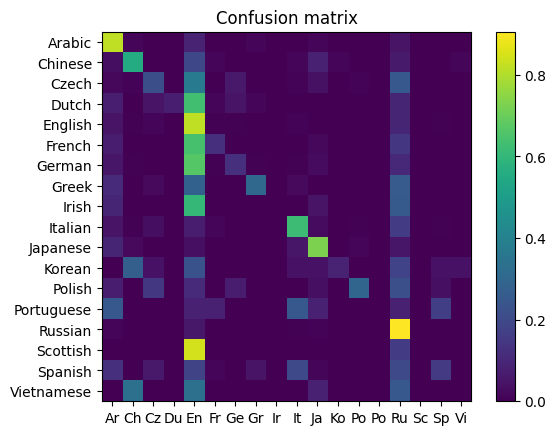

In [4]:
# test on a couple of examples
print(f'NAME; TRUTH; PREDICTED')
for i in range(10):
    name, country, name_tensor, country_tensor = test_dataset[i]
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {country}; {rnn.outputToCountry(output)}')

# confusion matrix
confusion = torch.zeros(N_COUNTRIES, N_COUNTRIES)
accuracy = 0
for iter, (name, country, name_tensor, country_tensor) in enumerate(test_loader):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[0][i], hidden)
    guess, guess_i = output.topk(1)
    category_i = country_tensor[0][None]
    confusion[category_i, guess_i] += 1
    if category_i == guess_i:
        accuracy += 1
# normalize by dividing every row by its sum
for i in range(N_COUNTRIES):
    confusion[i] = confusion[i] / confusion[i].sum()
# accuracy
print(f'Accuracy: {100*accuracy/len(test_dataset):.2f}%')

# plot confusion matrix
plt.imshow(confusion.numpy())
plt.colorbar()
plt.title('Confusion matrix')
ax = plt.gca()
positions = list(range(N_COUNTRIES))
labels = train_dataset.dataset.idx_to_country
small_labels = [label[:2] for label in labels]
ax.xaxis.set_major_locator(ticker.FixedLocator(positions))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(small_labels))
ax.yaxis.set_major_locator(ticker.FixedLocator(positions))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(labels))
plt.show()

The accuracy increased! (75% vs 60% last time)

Let's try a couple of examples of our own:

In [5]:
names = ["Dupont", "Garcia", "Sato", "Duprès", "Suzuki", "Wang", "Santos", "Yamamoto"]
for name in names:
    name_tensor = nameToTensor(name)
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(name_tensor.size()[1]):
        output, hidden = rnn(name_tensor[i], hidden)
    print(f'{name}; {rnn.outputToCountry(output)}')

Dupont; English
Garcia; English
Sato; English
Duprès; English
Suzuki; English
Wang; English
Santos; English
Yamamoto; English


It's almost always english/russian that is predicted!

This is typical of a class unbalance, let's investigate the size of each class:

In [7]:
# cout each country in the dataset
countr_count = {}
for country in dataset.countries:
    countr_count[country] = countr_count.get(country, 0) + 1
countr_count

{'Arabic': 2000,
 'Chinese': 268,
 'Czech': 519,
 'Dutch': 297,
 'English': 3668,
 'French': 277,
 'German': 724,
 'Greek': 203,
 'Irish': 232,
 'Italian': 709,
 'Japanese': 991,
 'Korean': 94,
 'Polish': 139,
 'Portuguese': 74,
 'Russian': 9408,
 'Scottish': 100,
 'Spanish': 298,
 'Vietnamese': 73}